# Text Classification with Sklearn (Core)
- David Atkins

## Core 1 Assignment

### Setup & Data Load/Clean

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy

from wordcloud import WordCloud
from nltk.probability import FreqDist
from string import punctuation
from custom_functions import spacy_process #, batch_preprocess_texts

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading data
df = pd.read_csv('data\Fake_Real_News_Data.csv')
df.head(10)



Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   
5           5   
6           6   
7           7   
8           8   
9           9   

                                                                             title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   
5                                         Can the great nuclear war be prevented ?   
6                     US charges 61 with India-based scam involving 15,000 victims   
7      Democratic debate 2015: Hillary Clinton and Bernie Sanders finally face off   
8                                What DNC Donors REALLY think of African Americans   
9                     What happens to delegates won by Rubio, other ex-candidates?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [4]:
df.duplicated().sum()

0

In [5]:
# dropping Unnamed: 0
df = df.drop(columns='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


### Prepare Data

##### Functions

In [6]:
#defining the spacy processing function
def spacy_process(text):
        """Lemmatize tokens, lower case, remove punctuation, spaces, and stop words"""
        doc = nlp_model(text)
        processed_doc = [token.lemma_ for token in doc if not token.is_punct and 
                         not token.is_space and not token.is_stop and 
                         not 'http' in token.lemma_ and 'www' not in token.lemma_]
        return processed_doc

##### Prep

In [7]:
# normalizing to all lower case
df['text'] = df['text'].str.lower()

In [8]:
# creating token column
df['tokens'] = df['text'].str.split()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
 3   tokens  6335 non-null   object
dtypes: object(4)
memory usage: 198.1+ KB


In [9]:
# loading in SpaCy NLP
nlp_model = spacy.load('en_core_web_sm', disable=['parser','ner'])
nlp_model.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [10]:
# applying spacy_process to the text in new column
df['spacy_lemmas'] = df['text'].apply(spacy_process)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         6335 non-null   object
 1   text          6335 non-null   object
 2   label         6335 non-null   object
 3   tokens        6335 non-null   object
 4   spacy_lemmas  6335 non-null   object
dtypes: object(5)
memory usage: 247.6+ KB


In [11]:
df['spacy_lemmas'].head(2)

0    [donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s, military, presence, asia, foreign, policy, position, outline, meeting, editorial, board, washington, post, come, day, trump, set, aside, guerrilla, tactic, showman, bravado, power, campaign, appear, presidential, nominee, explain, policy, accept, counsel, build, bridge, republican, elite, monday, night, trump, deliver, scripted, address, american, israel, public, affairs, committee, prompt, ovation, pledge, stand, israel, hard, line, peace, talk, palestinians, trump, whirlwind, day, appearance, nation, capital, intend, head, establishment, push, deny, republican, party, nomination, post, meeting, billionaire, mogul, clear, beholden, gop, ...]
1     [justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include

In [12]:
# making a joined string column
df['joined_lemmas'] = df['spacy_lemmas']
for i in range(len(df['spacy_lemmas'])):
    token = df['spacy_lemmas'][i]
    df['joined_lemmas'][i] = ' '.join(token)

# testing to make sure it worked
test0 = df['joined_lemmas'][0]
test1 = df['joined_lemmas'][1]
print(f'0: {test0[:100]}')
print(f'1: {test1[:100]}')

0: donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washi
1: justice department investigation adversarial new model collaborative reform surprising police city f


### Analyze Class Balance and Document Lengths

In [13]:
# checking class balance
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [14]:
# filters
filter_real = df['label'] == 'REAL'
filter_fake = df['label'] == 'FAKE'
filter_real.sum(), filter_fake.sum()

(3171, 3164)

In [15]:
# making a word count column
df['word_count'] = pd.Series
for i in range(len(df['tokens'])):
    token = df['tokens'][i]
    df['word_count'][i] = len(token)

df['word_count'].head(3)

0    1428
1    1091
2     408
Name: word_count, dtype: object

In [16]:
avg_real = np.average(df['word_count'].loc[filter_real])
avg_fake = np.average(df['word_count'].loc[filter_fake])
print('Average Word Count')
print(f'Real: {avg_real:.2f}')
print(f'Fake: {avg_fake:.2f}')

Average Word Count
Real: 873.26
Fake: 679.13


### Compare Word Frequencies

##### Frequency Distribution Plots

In [17]:
# making lists for the freq plot
real_lemmas_list = df.loc[filter_real, 'spacy_lemmas'].explode().to_list()
fake_lemmas_list = df.loc[filter_fake, 'spacy_lemmas'].explode().to_list()

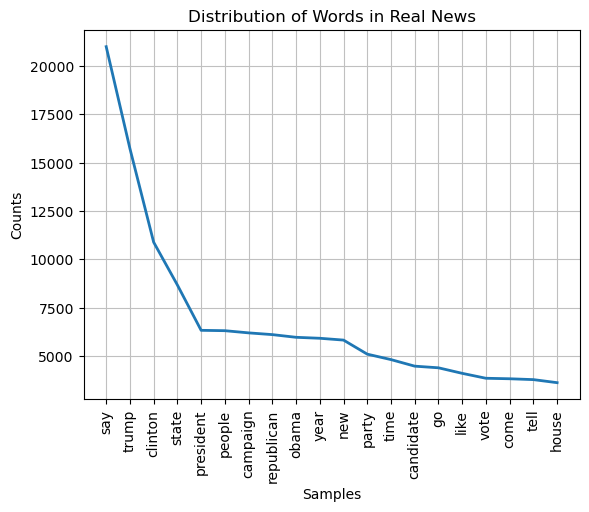

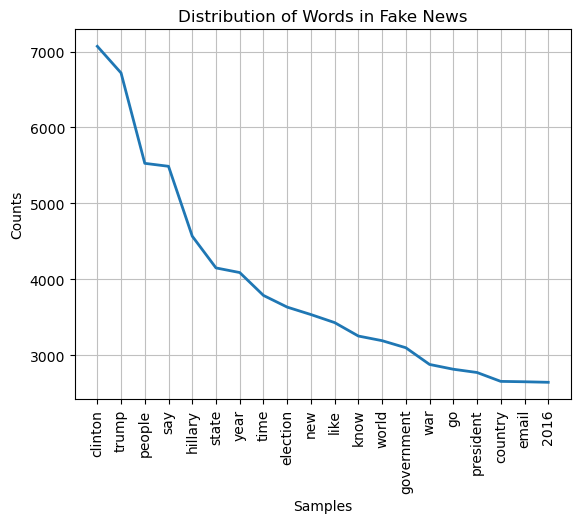

In [18]:
# plot for real news
real_dist = FreqDist(real_lemmas_list)
real_dist.plot(20, title='Distribution of Words in Real News');
# plot for fake news
fake_dist = FreqDist(fake_lemmas_list)
fake_dist.plot(20, title='Distribution of Words in Fake News');

##### Word Cloud

In [19]:
# connecting strings
real_text = " ".join(df.loc[filter_real, 'joined_lemmas'])
fake_text = " ".join(df.loc[filter_fake, 'joined_lemmas'])
print(real_text[:500],"\n",fake_text[:500],"\n")

donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s military presence asia foreign policy position outline meeting editorial board washington post come day trump set aside guerrilla tactic showman bravado power campaign appear presidential nominee explain policy accept counsel build bridge republican elite monday night trump deliver scripted address american is 
 trump proudly declare people insult deserve andrew bradford october 27 2016 subscribe arrogance define insulting way thinking behave come believe well smart important people word donald trump perfectly exemplify arrogance prove fact appear good morning america thursday morning gop nominee readily defend insulting post twitter ok deserve trump declare believe fight people tell lie know power instrument frankly use agree revert maybe come careful exactly trump careful post social medium try mel

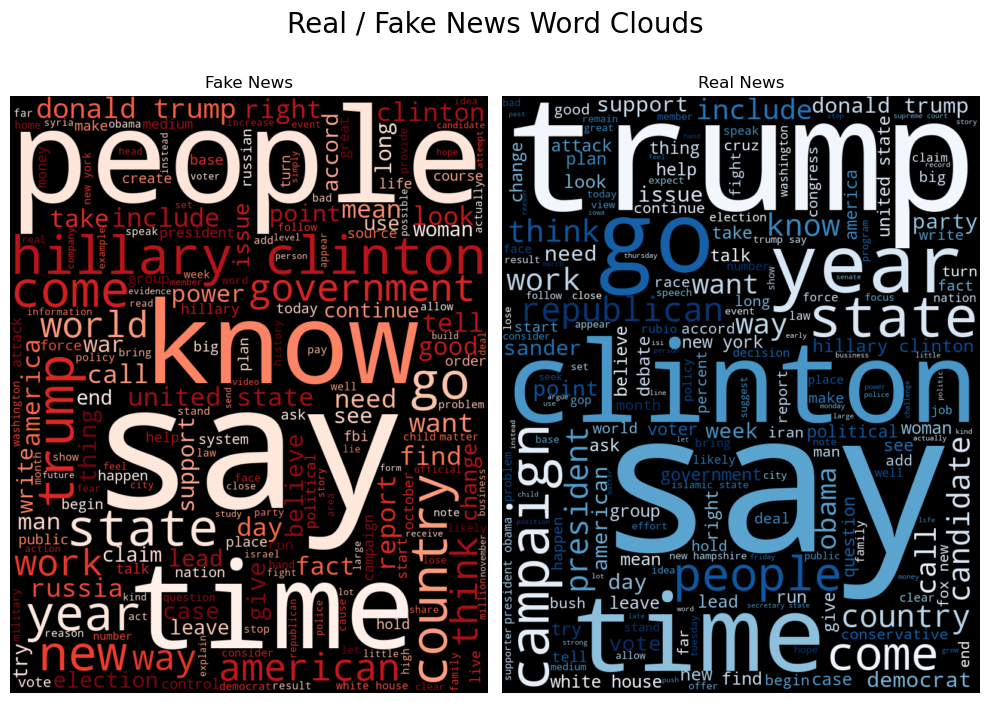

In [20]:
# creating word clouds
fake_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                     ).generate(fake_text)
real_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                      ).generate(real_text)
# adjusting the plot
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(fake_cloud, interpolation='bilinear')
axes[0].set_title("Fake News")
axes[1].imshow(real_cloud, interpolation='bilinear')
axes[1].set_title("Real News")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Real / Fake News Word Clouds', fontsize=20, y=1.05);

## Core 2 Assignment

##### Setup

In [46]:
# additional imports
import itertools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_colwidth',300)

In [60]:
# classification function
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [26]:
# checking on data
df[['joined_lemmas','label']].head(3)

,joined_lemmas,label
0,donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s military presence asia foreign policy position outline meeting editorial board washington post come day tru...,REAL
1,justice department investigation adversarial new model collaborative reform surprising police city find include solution search framework heal baltimore mayor stephanie rawling blake 911 department justice ask civil right investigation baltimore police department beat cop tactic week local prose...,REAL
2,trump proudly declare people insult deserve andrew bradford october 27 2016 subscribe arrogance define insulting way thinking behave come believe well smart important people word donald trump perfectly exemplify arrogance prove fact appear good morning america thursday morning gop nominee readil...,FAKE


##### Preparing Parameter Grids

In [31]:
# define X and y
X = df['joined_lemmas']
y = df['label']

In [32]:
# checking class balance 
y.value_counts(normalize=True)

REAL    0.500552
FAKE    0.499448
Name: label, dtype: float64

In [36]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [51]:
# pipeline setup
vect_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',MultinomialNB())])

In [54]:
# vectorizer params
param_grid_shared = {
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    'vectorizer__max_features': [None, 1000, 2000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}

param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    'vectorizer__use_idf': [True, False],
    **param_grid_shared
}

vect_params_combined = [param_grid_count, param_grid_tfidf]

In [55]:
# model params
param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

# including this because I have the time and am curious
param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]

In [56]:
# using itertools for the final parameter grid
paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__ngram_range': [(1, 1), (1, 2)],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

##### GridSearch

In [57]:
%%time
# create / fit GridSearch
grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
CPU times: total: 3min 8s
Wall time: 51min 2s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectori...
                          'vectorizer__use_idf': [True, False]},
                         {'clf': [LogisticRegression(random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [TfidfVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range': [(1, 1), (1, 2)],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

In [58]:
# best params
grid_search.best_params_

{'clf': LogisticRegression(random_state=42),
 'clf__C': 100,
 'vectorizer': TfidfVectorizer(),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 4,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2393
        REAL       1.00      1.00      1.00      2358

    accuracy                           1.00      4751
   macro avg       1.00      1.00      1.00      4751
weighted avg       1.00      1.00      1.00      4751



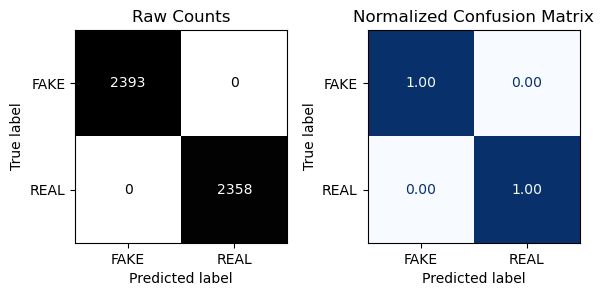


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.92      0.96      0.94       771
        REAL       0.96      0.93      0.94       813

    accuracy                           0.94      1584
   macro avg       0.94      0.94      0.94      1584
weighted avg       0.94      0.94      0.94      1584



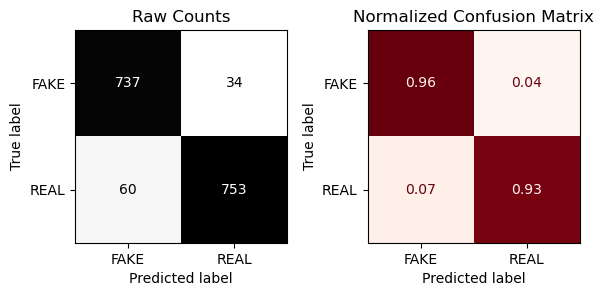

In [61]:
# evaluating best model
best_model = grid_search.best_estimator_
evaluate_classification(best_model, X_train, y_train, X_test, y_test)